In [1]:
# Magic Wand Gesture Classification - CNN 1D
#Model do rozpoznawania gestów magicznej różdżki na podstawie danych IMU (akcelerometr + żyroskop)

## 1. Import bibliotek

In [9]:
import numpy as np
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.20.0
Keras version: 3.12.0


## 2. Wczytanie danych

In [10]:
def load_gesture_data(folder_path, gesture_name):
    """
    Wczytuje wszystkie pliki CSV z danego folderu
    Zwraca listę sekwencji (każda sekwencja to macierz [timesteps, 6_features])
    """
    files = glob.glob(os.path.join(folder_path, '*.csv'))
    sequences = []
    
    for file in files:
        df = pd.read_csv(file)
        # Usuwamy kolumnę time, zostawiamy tylko 6 cech IMU
        # acc_X, acc_Y, acc_Z, gyro_X, gyro_Y, gyro_Z
        features = df[['acc_X', 'acc_Y', 'acc_Z', 'gyro_X', 'gyro_Y', 'gyro_Z']].values
        sequences.append(features)
    
    print(f"{gesture_name}: {len(sequences)} próbek")
    return sequences

# Wczytaj dane dla każdego gestu
alohomora_data = load_gesture_data('alohomora', 'Alohomora')
lumos_data = load_gesture_data('lumos', 'Lumos')
wingardium_data = load_gesture_data('wingardium', 'Wingardium')
avada_data = load_gesture_data('avada3', 'Avada')

Alohomora: 50 próbek
Lumos: 30 próbek
Wingardium: 50 próbek
Avada: 40 próbek


## 3. Analiza długości sekwencji

In [11]:
# Sprawdź długości sekwencji
all_lengths = []
for data, name in [(alohomora_data, 'Alohomora'), 
                    (lumos_data, 'Lumos'), 
                    (wingardium_data, 'Wingardium'), 
                    (avada_data, 'Avada')]:
    lengths = [len(seq) for seq in data]
    all_lengths.extend(lengths)
    print(f"{name}: min={min(lengths)}, max={max(lengths)}, avg={np.mean(lengths):.1f}")

print(f"\nWszystkie: min={min(all_lengths)}, max={max(all_lengths)}, avg={np.mean(all_lengths):.1f}")

# Ustalamy stałą długość sekwencji (weźmiemy 100 - jak w Arduino)
MAX_SEQUENCE_LENGTH = 100

Alohomora: min=100, max=100, avg=100.0
Lumos: min=100, max=100, avg=100.0
Wingardium: min=100, max=100, avg=100.0
Avada: min=100, max=100, avg=100.0

Wszystkie: min=100, max=100, avg=100.0


## 4. Preprocessing - padding i normalizacja

In [12]:
def pad_sequences(sequences, max_length):
    """
    Dopasowuje sekwencje do stałej długości
    - Jeśli za krótka: wypełnia zerami na końcu
    - Jeśli za długa: obcina do max_length
    """
    padded = []
    for seq in sequences:
        if len(seq) < max_length:
            # Padding zerami
            padding = np.zeros((max_length - len(seq), seq.shape[1]))
            padded_seq = np.vstack([seq, padding])
        else:
            # Obcinamy do max_length
            padded_seq = seq[:max_length]
        padded.append(padded_seq)
    return np.array(padded)

# Przygotowanie danych
X_alohomora = pad_sequences(alohomora_data, MAX_SEQUENCE_LENGTH)
X_lumos = pad_sequences(lumos_data, MAX_SEQUENCE_LENGTH)
X_wingardium = pad_sequences(wingardium_data, MAX_SEQUENCE_LENGTH)
X_avada = pad_sequences(avada_data, MAX_SEQUENCE_LENGTH)

# Łączymy wszystkie dane
X = np.vstack([X_alohomora, X_lumos, X_wingardium, X_avada])

# Etykiety (0: alohomora, 1: lumos, 2: wingardium, 3: avada)
y_alohomora = np.zeros(len(X_alohomora), dtype=int)
y_lumos = np.ones(len(X_lumos), dtype=int)
y_wingardium = np.full(len(X_wingardium), 2, dtype=int)
y_avada = np.full(len(X_avada), 3, dtype=int)

y = np.concatenate([y_alohomora, y_lumos, y_wingardium, y_avada])

print(f"Kształt danych X: {X.shape}")  # (total_samples, 100, 6)
print(f"Kształt etykiet y: {y.shape}")  # (total_samples,)
print(f"Rozkład klas: {np.bincount(y)}")

Kształt danych X: (170, 100, 6)
Kształt etykiet y: (170,)
Rozkład klas: [50 30 50 40]


## 5. Podział na zbiór treningowy i testowy

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Treningowy: {X_train.shape[0]} próbek")
print(f"Testowy: {X_test.shape[0]} próbek")

Treningowy: 136 próbek
Testowy: 34 próbek


## 6. Budowa modelu CNN 1D

In [14]:
def create_cnn_model(input_shape, num_classes):
    """
    CNN 1D zoptymalizowany dla microcontrollerów (Arduino Nano 33 BLE Sense)
    - Bardzo małe warstwy (aby zmieścić się w 1MB flash)
    - BatchNormalization dla stabilności
    - Dropout dla regularyzacji
    """
    model = keras.Sequential([
        # Pierwsza warstwa konwolucyjna (zmniejszono z 16 do 8)
        layers.Conv1D(8, kernel_size=5, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),
        
        # Druga warstwa konwolucyjna (zmniejszono z 32 do 16)
        layers.Conv1D(16, kernel_size=5, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),
        
        # Trzecia warstwa konwolucyjna (zmniejszono z 64 do 32)
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        # Flatten i warstwy gęste (zmniejszono rozmiary)
        layers.Flatten(),
        layers.Dense(32, activation='relu'),  # zmniejszono z 64 do 32
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),  # zmniejszono z 32 do 16
        layers.Dropout(0.2),
        
        # Warstwa wyjściowa
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Tworzenie modelu
model = create_cnn_model(input_shape=(MAX_SEQUENCE_LENGTH, 6), num_classes=4)
model.summary()

# Informacja o rozmiarze modelu
param_count = model.count_params()
print(f"\nLiczba parametrów: {param_count:,}")
print(f"Przybliżony rozmiar (float32): ~{param_count * 4 / 1024:.1f} KB")

c:\Users\Olek\.platformio\penv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 96, 8)          │           248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 44, 16)         │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 44, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 22, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 20, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,564 (52.98 KB)

 Trainable params: 13,452 (52.55 KB)

 Non-trainable params: 112 (448.00 B)


Liczba parametrów: 13,564
Przybliżony rozmiar (float32): ~53.0 KB


## 7. Kompilacja i trening

In [15]:
# Kompilacja
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

# Trening
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.2315 - loss: 1.9710 - val_accuracy: 0.3571 - val_loss: 1.5385 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2685 - loss: 1.8098 - val_accuracy: 0.3214 - val_loss: 1.3036 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3333 - loss: 1.5160 - val_accuracy: 0.3929 - val_loss: 1.2101 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3611 - loss: 1.5276 - val_accuracy: 0.4286 - val_loss: 1.1868 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4167 - loss: 1.4050 - val_accuracy: 0.4286 - val_loss: 1.2086 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3241 - loss: 1.4954 - val_accuracy: 0.4286 - val_loss: 1.2264 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4630 - loss: 1.2367 - val_accuracy:

## 8. Wizualizacja wyników treningu

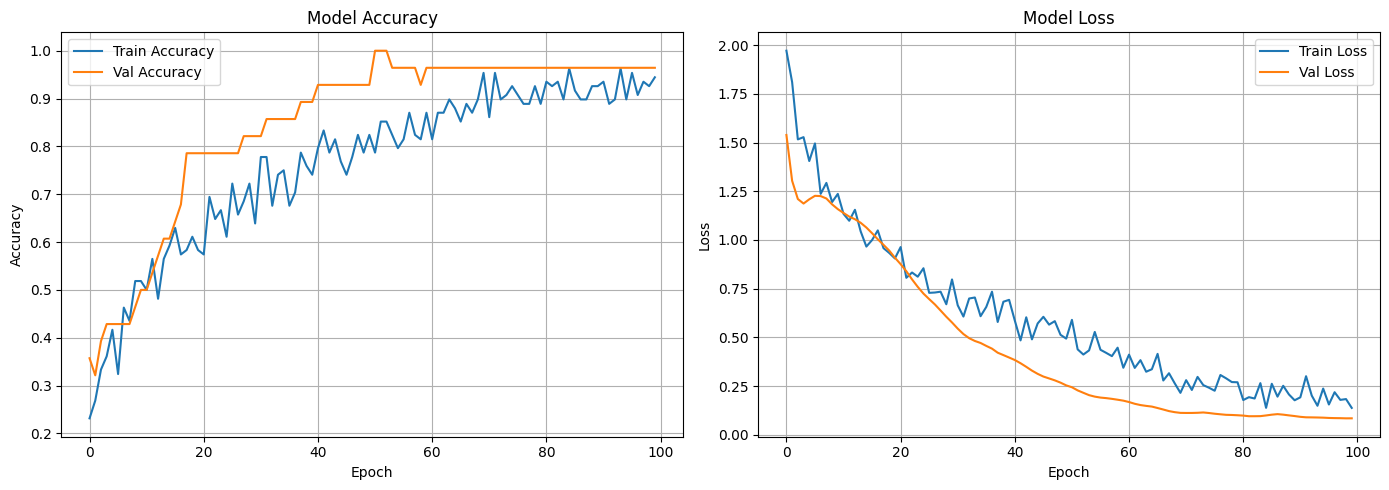

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 9. Ewaluacja na zbiorze testowym

In [17]:
# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Dokładność
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Classification report
class_names = ['alohomora', 'lumos', 'wingardium', 'avada']
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9118 - loss: 0.1428

Test Accuracy: 0.9118
Test Loss: 0.1428

Classification Report:
              precision    recall  f1-score   support

   alohomora       0.91      1.00      0.95        10
       lumos       0.86      1.00      0.92         6
  wingardium       1.00      0.70      0.82        10
       avada       0.89      1.00      0.94         8

    accuracy                           0.91        34
   macro avg       0.91      0.93      0.91        34
weighted avg       0.92      0.91      0.91        34



## 10. Confusion Matrix

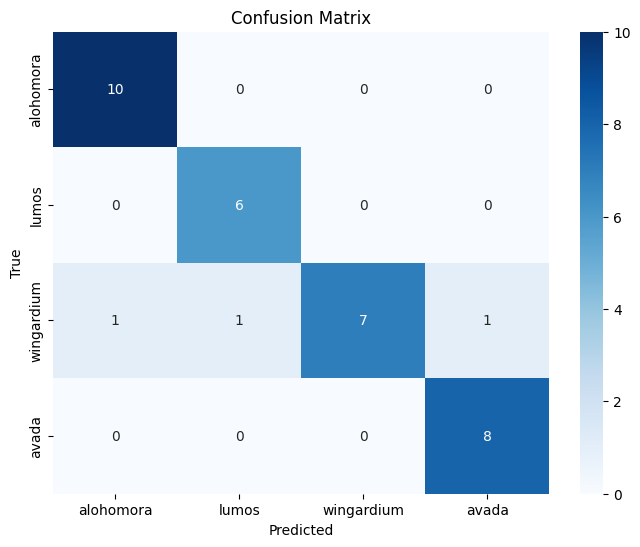

In [18]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 11. Zapis modelu

In [19]:
# Zapis modelu w formacie Keras (.h5)
model.save('gesture_model_cnn.h5')
print("Model zapisany jako gesture_model_cnn.h5")

# Zapis również w nowym formacie Keras 3 (.keras)
model.save('gesture_model_cnn.keras')
print("Model zapisany jako gesture_model_cnn.keras")

Model zapisany jako gesture_model_cnn.h5
Model zapisany jako gesture_model_cnn.keras


## 12. Konwersja do TensorFlow Lite (dla microcontrollerów)

In [20]:
# Konwersja do TensorFlow Lite z kwantyzacją INT8 dla Arduino
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# KWANTYZACJA INT8 - drastycznie zmniejsza rozmiar modelu (4x mniej)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Funkcja reprezentatywna dla kwantyzacji (próbki danych treningowych)
def representative_dataset():
    for i in range(100):
        # Wybierz losową próbkę z danych treningowych
        idx = np.random.randint(0, len(X_train))
        sample = X_train[idx:idx+1].astype(np.float32)
        yield [sample]

converter.representative_dataset = representative_dataset

# Wymuszenie pełnej kwantyzacji INT8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Konwersja
tflite_model_quant = converter.convert()

# Zapis skwantyzowanego modelu
with open('gesture_model_cnn.tflite', 'wb') as f:
    f.write(tflite_model_quant)

print(f"TFLite model (INT8 quantized) zapisany: {len(tflite_model_quant):,} bajtów")
print(f"Rozmiar: {len(tflite_model_quant) / 1024:.1f} KB")
print(f"Model zmieści się w Arduino Nano 33 BLE Sense (1MB flash): {'TAK ✓' if len(tflite_model_quant) < 1024*1024 else 'NIE ✗'}")

# Konwersja do C array (dla Arduino)
def convert_to_c_array(tflite_model, output_file='model.h'):
    """Konwertuje model TFLite do tablicy C dla Arduino"""
    
    c_str = '#ifndef MODEL_H\n'
    c_str += '#define MODEL_H\n\n'
    c_str += '// Model size: ' + str(len(tflite_model)) + ' bytes\n'
    c_str += '// Quantized to INT8 for Arduino Nano 33 BLE Sense\n\n'
    c_str += 'const unsigned char model_tflite[] = {\n  '
    
    hex_array = [f'0x{byte:02x}' for byte in tflite_model]
    
    # Formatuj po 12 elementów w linii
    for i, hex_val in enumerate(hex_array):
        c_str += hex_val
        if i < len(hex_array) - 1:
            c_str += ', '
        if (i + 1) % 12 == 0:
            c_str += '\n  '
    
    c_str += '\n};\n'
    c_str += f'const unsigned int model_tflite_len = {len(tflite_model)};\n\n'
    c_str += '#endif\n'
    
    with open(output_file, 'w') as f:
        f.write(c_str)
    
    print(f"C header zapisany jako: {output_file}")

# Generuj plik .h dla Arduino
convert_to_c_array(tflite_model_quant, 'gesture_model_cnn.h')

print("\n⚠️ WAŻNE dla Arduino:")
print("1. Model jest skwantyzowany do INT8")
print("2. Input i output są typu INT8 (nie FLOAT32)")
print("3. Musisz skalować dane wejściowe przed przekazaniem do modelu")
print("4. Musisz deskalować wyniki z modelu")

INFO:tensorflow:Assets written to: C:\Users\Olek\AppData\Local\Temp\tmpo61fxihw\assets


INFO:tensorflow:Assets written to: C:\Users\Olek\AppData\Local\Temp\tmpo61fxihw\assets


Saved artifact at 'C:\Users\Olek\AppData\Local\Temp\tmpo61fxihw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2354985556624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2354985557200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2354985558736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2354985559696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2354985559504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2354985559312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2354985560080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2354985559888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2354985558928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2354985557968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23549855577

c:\Users\Olek\.platformio\penv\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


TFLite model (INT8 quantized) zapisany: 28,800 bajtów
Rozmiar: 28.1 KB
Model zmieści się w Arduino Nano 33 BLE Sense (1MB flash): TAK ✓
C header zapisany jako: gesture_model_cnn.h

⚠️ WAŻNE dla Arduino:
1. Model jest skwantyzowany do INT8
2. Input i output są typu INT8 (nie FLOAT32)
3. Musisz skalować dane wejściowe przed przekazaniem do modelu
4. Musisz deskalować wyniki z modelu


## 13. Test pojedynczej predykcji

In [26]:
# Test na przykładowej próbce
sample_idx = 0
sample = X_test[sample_idx:sample_idx+1]
true_label = y_test[sample_idx]
print(sample)
prediction = model.predict(sample, verbose=0)
predicted_class = np.argmax(prediction)
confidence = prediction[0][predicted_class]

print(f"Prawdziwa klasa: {class_names[true_label]}")
print(f"Przewidziana klasa: {class_names[predicted_class]}")
print(f"Pewność: {confidence:.2%}")
print(f"\nWszystkie prawdopodobieństwa:")
for i, prob in enumerate(prediction[0]):
    print(f"  {class_names[i]}: {prob:.2%}")

[[[ 5.7000e-01 -3.0000e-02 -5.7000e-01 -1.8300e+00 -4.4490e+01
    2.6900e+00]
  [ 5.4000e-01  9.0000e-02 -6.5000e-01  2.2460e+01 -3.2410e+01
   -1.6500e+00]
  [ 5.5000e-01  6.0000e-02 -6.2000e-01  3.5340e+01 -2.8140e+01
   -8.5400e+00]
  [ 5.3000e-01  2.0000e-02 -5.9000e-01  1.2450e+01 -2.6860e+01
   -1.2270e+01]
  [ 5.4000e-01  6.0000e-02 -5.6000e-01  4.4600e+00 -2.8810e+01
   -1.2080e+01]
  [ 5.0000e-01  1.1000e-01 -5.1000e-01  1.0860e+01 -3.1680e+01
   -1.5690e+01]
  [ 4.3000e-01  9.0000e-02 -3.3000e-01  2.0260e+01 -2.8690e+01
   -2.6120e+01]
  [ 3.8000e-01 -6.0000e-02 -3.0000e-02 -3.9100e+00 -2.4000e-01
   -3.4910e+01]
  [ 3.1000e-01 -1.2000e-01 -1.0000e-01 -3.2530e+01  2.2830e+01
   -3.4360e+01]
  [ 2.5000e-01 -1.2000e-01 -2.0000e-01 -4.4800e+01  4.8520e+01
   -2.8080e+01]
  [ 2.1000e-01 -1.4000e-01 -2.0000e-01 -1.8680e+01  6.1160e+01
   -2.2090e+01]
  [ 2.5000e-01 -1.9000e-01 -4.9000e-01 -2.7280e+01  7.3490e+01
   -1.6420e+01]
  [ 2.6000e-01 -1.1000e-01 -6.6000e-01 -4.3880e+01  

## 14. Inspekcja operacji w modelu TFLite

In [18]:
import tensorflow as tf

# Załaduj model
interpreter = tf.lite.Interpreter(model_path="gesture_model_cnn.tflite")
interpreter.allocate_tensors()

# Pobierz wszystkie operacje
ops = set()
for detail in interpreter.get_tensor_details():
    ops.add(detail['name'])

# Wyświetl unikalne operacje
print("Operacje w modelu:")
for op in sorted(ops):
    print(op)

Operacje w modelu:
StatefulPartitionedCall_1:0
arith.constant
arith.constant1
arith.constant10
arith.constant2
arith.constant3
arith.constant4
arith.constant5
arith.constant6
arith.constant7
arith.constant8
arith.constant9
sequential_1/batch_normalization_1/batchnorm/add_1;sequential_1/conv1d_1/convolution/Squeeze;sequential_1/batch_normalization_1/batchnorm/mul_1;sequential_1/conv1d_1/Relu;sequential_1/conv1d_1/BiasAdd;
sequential_1/batch_normalization_1/batchnorm/add_1;sequential_1/conv1d_1/convolution/Squeeze;sequential_1/batch_normalization_1/batchnorm/mul_1;sequential_1/conv1d_1/Relu;sequential_1/conv1d_1/BiasAdd;1
sequential_1/batch_normalization_1/batchnorm/mul_1;sequential_1/conv1d_1/convolution/Squeeze;sequential_1/conv1d_1/Relu;sequential_1/conv1d_1/BiasAdd;
sequential_1/batch_normalization_1_2/batchnorm/add_1;sequential_1/conv1d_1_2/convolution/Squeeze;sequential_1/batch_normalization_1_2/batchnorm/mul_1;sequential_1/conv1d_1_2/Relu;sequential_1/conv1d_1_2/BiasAdd;
sequentia

c:\Users\Olek\OneDrive - put.poznan.pl\SEMESTR 6\NLP\lab6\myenv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
## 15. Obliczenie Tensor Arena Size dla Arduino

=== ANALIZA PAMIĘCI DLA ARDUINO ===

Input tensor size: 600 elementów
Input shape: [  1 100   6]
Input type: <class 'numpy.int8'>

Output tensor size: 4 elementów
Output shape: [1 4]
Output type: <class 'numpy.int8'>

=== WSZYSTKIE TENSORY ===


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Załaduj model TFLite
interpreter = tf.lite.Interpreter(model_path="gesture_model_int8.tflite")
interpreter.allocate_tensors()

# Pobierz wszystkie tensory
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
tensor_details = interpreter.get_tensor_details()

print("=== ANALIZA PAMIĘCI DLA ARDUINO ===\n")

# Rozmiar wejścia
input_size = np.prod(input_details[0]['shape'])
print(f"Input tensor size: {input_size} elementów")
print(f"Input shape: {input_details[0]['shape']}")
print(f"Input type: {input_details[0]['dtype']}")

# Rozmiar wyjścia
output_size = np.prod(output_details[0]['shape'])
print(f"\nOutput tensor size: {output_size} elementów")
print(f"Output shape: {output_details[0]['shape']}")
print(f"Output type: {output_details[0]['dtype']}")

# Suma wszystkich tensorów (przybliżona arena size)
total_tensor_size = 0
print("\n=== WSZYSTKIE TENSORY ===")
for i, detail in enumerate(tensor_details):
    tensor_size = np.prod(detail['shape']) if len(detail['shape']) > 0 else 0
    # INT8 = 1 bajt, FLOAT32 = 4 bajty
    if detail['dtype'] == np.int8:
        bytes_size = tensor_size * 1
    elif detail['dtype'] == np.float32:
        bytes_size = tensor_size * 4
    else:
        bytes_size = tensor_size * 2  # INT16/UINT16
    
    total_tensor_size += bytes_size
    if i < 10:  # Pokaż pierwsze 10
        print(f"{i}: {detail['name'][:50]:50s} Shape: {str(detail['shape']):20s} Size: {bytes_size:6d} B")

print(f"\n... (total {len(tensor_details)} tensors)")

# Rekomendowane rozmiary arena
recommended_min = total_tensor_size
recommended_safe = int(total_tensor_size * 1.5)  # +50% buffer
recommended_max = int(total_tensor_size * 2.0)   # +100% buffer

print(f"\n=== REKOMENDOWANE TENSOR ARENA SIZE ===")
print(f"Minimalna (suma tensorów):     {recommended_min:,} bajtów ({recommended_min/1024:.1f} KB)")
print(f"Bezpieczna (+50% buffer):      {recommended_safe:,} bajtów ({recommended_safe/1024:.1f} KB)")
print(f"Maksymalna (+100% buffer):     {recommended_max:,} bajtów ({recommended_max/1024:.1f} KB)")

print(f"\n=== ARDUINO NANO 33 BLE SENSE REV2 ===")
print(f"Dostępna SRAM: 256 KB (262,144 bajtów)")
print(f"Rozmiar modelu (flash): {len(tflite_model_quant)/1024:.1f} KB")
print(f"SRAM dla tensor arena: ~200 KB (po odjęciu stack, zmienne, bufory)")

# Zaokrąglij do wielokrotności 1024
arena_rounded = ((recommended_safe // 1024) + 1) * 1024

print(f"\n{'='*60}")
print(f"✓ UŻYJ W ARDUINO:")
print(f"{'='*60}")
print(f"constexpr int kTensorArenaSize = {arena_rounded};")
print(f"// czyli {arena_rounded/1024:.0f} KB")
print(f"{'='*60}")

# Sprawdź czy zmieści się w SRAM
if arena_rounded < 200 * 1024:
    print(f"\n✓ Model zmieści się w SRAM Arduino! ({arena_rounded/1024:.0f} KB < 200 KB)")
else:
    print(f"\n✗ UWAGA: Model może być za duży dla SRAM! ({arena_rounded/1024:.0f} KB > 200 KB)")
    print("   Rozważ dalsze zmniejszenie modelu (mniej filtrów/warstw)")
    
print("\nUWAGA: Jeśli w Arduino wystąpi błąd 'AllocateTensors() failed',")
print("       zwiększ kTensorArenaSize o 10-20 KB i spróbuj ponownie.")

=== ANALIZA PAMIĘCI DLA ARDUINO ===

Input tensor size: 600 elementów
Input shape: [  1 100   6]
Input type: <class 'numpy.int8'>

Output tensor size: 4 elementów
Output shape: [1 4]
Output type: <class 'numpy.int8'>

=== WSZYSTKIE TENSORY ===
0: serving_default_keras_tensor:0                     Shape: [  1 100   6]        Size:    600 B
1: arith.constant                                     Shape: []                   Size:      0 B
2: arith.constant1                                    Shape: [3]                  Size:      6 B
3: arith.constant2                                    Shape: []                   Size:      0 B
4: arith.constant3                                    Shape: [3]                  Size:      6 B
5: arith.constant4                                    Shape: [3]                  Size:      6 B
6: arith.constant5                                    Shape: [3]                  Size:      6 B
7: arith.constant6                                    Shape: [3]             

In [24]:
import tensorflow as tf
import numpy as np

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(100, 6)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Kwantyzuj
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Zapisz
with open('gesture_model_int8.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Olek\AppData\Local\Temp\tmpl3sezhyn\assets


c:\Users\Olek\OneDrive - put.poznan.pl\SEMESTR 6\NLP\lab6\myenv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
INFO:tensorflow:Assets written to: C:\Users\Olek\AppData\Local\Temp\tmpl3sezhyn\assets


Saved artifact at 'C:\Users\Olek\AppData\Local\Temp\tmpl3sezhyn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 6), dtype=tf.float32, name='keras_tensor_364')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2462499675344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462499678608: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [23]:
import tensorflow as tf
import numpy as np

# Załaduj model
model = tf.keras.models.load_model('twoj_model.h5')

# KLUCZOWE: Representative dataset dla INT8 quantization
def representative_dataset():
    # Użyj prawdziwych danych treningowych lub przykładowych
    for _ in range(100):
        # Przykładowe dane - ZASTĄP swoimi prawdziwymi danymi treningowymi!
        data = np.random.uniform(-10, 10, (1, 100, 6)).astype(np.float32)
        yield [data]

# Konwersja z FULL INT8 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # WAŻNE!
converter.inference_output_type = tf.int8  # WAŻNE!

# Konwertuj
tflite_model = converter.convert()

# Zapisz
with open('gesture_model_int8.tflite', 'wb') as f:
    f.write(tflite_model)

# Konwertuj do C array
import binascii
with open('gesture_model_int8.tflite', 'rb') as f:
    tflite_binary = f.read()

hex_array = ', '.join([f'0x{b:02x}' for b in tflite_binary])

with open('gesture_model_cnn.h', 'w') as f:
    f.write(f'const unsigned int model_tflite_len = {len(tflite_binary)};\n')
    f.write(f'const unsigned char model_tflite[] = {{\n  ')
    f.write(hex_array)
    f.write('\n};\n')

print(f"Model size: {len(tflite_binary)} bytes")

INFO:tensorflow:Assets written to: C:\Users\Olek\AppData\Local\Temp\tmpfdyghqcl\assets


INFO:tensorflow:Assets written to: C:\Users\Olek\AppData\Local\Temp\tmpfdyghqcl\assets


Saved artifact at 'C:\Users\Olek\AppData\Local\Temp\tmpfdyghqcl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 6), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2462677476816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462699525264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462699533712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462754356496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462699524304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462699524496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462754356112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462754356304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462754354192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462754355152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  246275435361

c:\Users\Olek\OneDrive - put.poznan.pl\SEMESTR 6\NLP\lab6\myenv\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model size: 28800 bytes


In [24]:
import tensorflow as tf
import numpy as np

# Załaduj model TFLite
interpreter = tf.lite.Interpreter(model_path="gesture_model_cnn.tflite")
interpreter.allocate_tensors()

# Pobierz szczegóły input/output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("="*70)
print("WERYFIKACJA KWANTYZACJI MODELU gesture_model_cnn.tflite")
print("="*70)

print("\n### INPUT TENSOR ###")
print(f"Name: {input_details[0]['name']}")
print(f"Shape: {input_details[0]['shape']}")
print(f"Type: {input_details[0]['dtype']}")
print(f"Quantization: {input_details[0]['quantization']}")
print(f"Quantization parameters: {input_details[0]['quantization_parameters']}")

if input_details[0]['dtype'] == np.int8:
    print("✓ INPUT jest INT8 (model skwantyzowany)")
    print(f"  Scale: {input_details[0]['quantization_parameters']['scales'][0]}")
    print(f"  Zero point: {input_details[0]['quantization_parameters']['zero_points'][0]}")
elif input_details[0]['dtype'] == np.float32:
    print("✗ INPUT jest FLOAT32 (model NIE jest skwantyzowany!)")
else:
    print(f"? INPUT jest typu {input_details[0]['dtype']}")

print("\n### OUTPUT TENSOR ###")
print(f"Name: {output_details[0]['name']}")
print(f"Shape: {output_details[0]['shape']}")
print(f"Type: {output_details[0]['dtype']}")
print(f"Quantization: {output_details[0]['quantization']}")
print(f"Quantization parameters: {output_details[0]['quantization_parameters']}")

if output_details[0]['dtype'] == np.int8:
    print("✓ OUTPUT jest INT8 (model skwantyzowany)")
    print(f"  Scale: {output_details[0]['quantization_parameters']['scales'][0]}")
    print(f"  Zero point: {output_details[0]['quantization_parameters']['zero_points'][0]}")
elif output_details[0]['dtype'] == np.float32:
    print("✗ OUTPUT jest FLOAT32 (model NIE jest skwantyzowany!)")
else:
    print(f"? OUTPUT jest typu {output_details[0]['dtype']}")

print("\n### WSZYSTKIE OPERACJE W MODELU ###")
tensor_details = interpreter.get_tensor_details()
op_types = set()
for detail in tensor_details:
    if 'name' in detail:
        # Extract op type from tensor name if possible
        name = detail['name']
        if ';' in name:
            op_type = name.split(';')[0]
            op_types.add(op_type)

print(f"Liczba tensorów: {len(tensor_details)}")
print("\nTypy operacji:")
for op in sorted(op_types):
    print(f"  - {op}")

print("\n### ROZMIAR MODELU ###")
import os
model_size = os.path.getsize("gesture_model_cnn.tflite")
print(f"Rozmiar pliku: {model_size:,} bajtów ({model_size/1024:.2f} KB)")

print("\n### ANALIZA TENSORÓW WEWNĘTRZNYCH ###")
int8_count = 0
float32_count = 0
other_count = 0

for detail in tensor_details:
    if detail['dtype'] == np.int8:
        int8_count += 1
    elif detail['dtype'] == np.float32:
        float32_count += 1
    else:
        other_count += 1

print(f"Tensory INT8: {int8_count}")
print(f"Tensory FLOAT32: {float32_count}")
print(f"Tensory inne: {other_count}")

if float32_count > 0:
    print("\n⚠️ UWAGA: Model zawiera tensory FLOAT32!")
    print("   Model może nie być w pełni skwantyzowany do INT8.")
    print("   Należy przekonwertować model ponownie z pełną kwantyzacją.")
else:
    print("\n✓ Model jest w pełni skwantyzowany do INT8")

print("\n" + "="*70)
print("WNIOSEK:")
if input_details[0]['dtype'] == np.int8 and output_details[0]['dtype'] == np.int8 and float32_count == 0:
    print("✓✓✓ Model jest POPRAWNIE skwantyzowany do INT8")
    print("     Plik gesture_model_cnn.h powinien działać na Arduino")
else:
    print("✗✗✗ Model NIE jest poprawnie skwantyzowany!")
    print("     Należy przekonwertować model ponownie z pełną kwantyzacją INT8")
print("="*70)

WERYFIKACJA KWANTYZACJI MODELU gesture_model_cnn.tflite

### INPUT TENSOR ###
Name: serving_default_keras_tensor:0
Shape: [  1 100   6]
Type: <class 'numpy.int8'>
Quantization: (4.328470706939697, -21)
Quantization parameters: {'scales': array([4.3284707], dtype=float32), 'zero_points': array([-21], dtype=int32), 'quantized_dimension': 0}
✓ INPUT jest INT8 (model skwantyzowany)
  Scale: 4.328470706939697
  Zero point: -21

### OUTPUT TENSOR ###
Name: StatefulPartitionedCall_1:0
Shape: [1 4]
Type: <class 'numpy.int8'>
Quantization: (0.00390625, -128)
Quantization parameters: {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}
✓ OUTPUT jest INT8 (model skwantyzowany)
  Scale: 0.00390625
  Zero point: -128

### WSZYSTKIE OPERACJE W MODELU ###
Liczba tensorów: 62

Typy operacji:
  - sequential_1/batch_normalization_1/batchnorm/add_1
  - sequential_1/batch_normalization_1/batchnorm/mul_1
  - sequential_1/batch_normalization_1_2

In [25]:
import tensorflow as tf
import numpy as np

# Załaduj model TFLite
interpreter = tf.lite.Interpreter(model_path="gesture_model_cnn.tflite")
interpreter.allocate_tensors()

# Pobierz wszystkie tensory
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
tensor_details = interpreter.get_tensor_details()

print("="*70)
print("OBLICZENIE TENSOR ARENA SIZE DLA ARDUINO")
print("="*70)

# Analiza rozmiarów tensorów
total_size = 0
max_tensor_size = 0

print("\nTop 10 największych tensorów:")
tensor_sizes = []
for detail in tensor_details:
    if len(detail['shape']) > 0:
        size = np.prod(detail['shape'])
        if detail['dtype'] == np.int8:
            bytes_size = size * 1
        elif detail['dtype'] == np.float32:
            bytes_size = size * 4
        elif detail['dtype'] == np.int32:
            bytes_size = size * 4
        else:
            bytes_size = size * 2
        
        tensor_sizes.append((detail['name'], bytes_size, detail['shape'], detail['dtype']))
        total_size += bytes_size
        max_tensor_size = max(max_tensor_size, bytes_size)

# Sortuj i pokaż największe
tensor_sizes.sort(key=lambda x: x[1], reverse=True)
for i, (name, size, shape, dtype) in enumerate(tensor_sizes[:10]):
    print(f"{i+1:2d}. {name[:50]:50s} {size:6d} B  {str(shape):20s}")

print(f"\nSuma wszystkich tensorów: {total_size:,} bajtów ({total_size/1024:.2f} KB)")
print(f"Największy tensor: {max_tensor_size:,} bajtów ({max_tensor_size/1024:.2f} KB)")

# Rekomendowane rozmiary (TFLite potrzebuje buffer dla operations)
recommended_min = total_size
recommended_safe = int(total_size * 2.0)   # 2x dla pewności
recommended_max = int(total_size * 3.0)    # 3x dla maksymalnej pewności

print(f"\n{'='*70}")
print("REKOMENDOWANE TENSOR ARENA SIZE:")
print(f"{'='*70}")
print(f"Minimum (suma tensorów):       {recommended_min:6,} B ({recommended_min/1024:5.1f} KB)")
print(f"Zalecane (2x buffer):         {recommended_safe:6,} B ({recommended_safe/1024:5.1f} KB)")
print(f"Maksymum (3x buffer):         {recommended_max:6,} B ({recommended_max/1024:5.1f} KB)")

# Zaokrąglij do wielokrotności 1024
arena_1x = ((recommended_min // 1024) + 1) * 1024
arena_2x = ((recommended_safe // 1024) + 1) * 1024
arena_3x = ((recommended_max // 1024) + 1) * 1024

print(f"\n{'='*70}")
print("WARTOŚCI DO UŻYCIA W ARDUINO:")
print(f"{'='*70}")
print(f"Opcja 1 (minimalna - może nie wystarczyć):")
print(f"  #define TENSOR_ARENA_SIZE {arena_1x:,}  // {arena_1x//1024} KB")
print(f"\nOpcja 2 (zalecana - bezpieczna): ⭐")
print(f"  #define TENSOR_ARENA_SIZE {arena_2x:,}  // {arena_2x//1024} KB")
print(f"\nOpcja 3 (maksymalna - najbezpieczniejsza):")
print(f"  #define TENSOR_ARENA_SIZE {arena_3x:,}  // {arena_3x//1024} KB")

print(f"\n{'='*70}")
print("ARDUINO NANO 33 BLE SENSE - Dostępna pamięć:")
print(f"{'='*70}")
print(f"Flash (program): 1 MB")
print(f"SRAM (runtime): 256 KB")
print(f"Model size: {len(tflite_model_quant)/1024:.1f} KB (w flash)")
print(f"Arena dla tensorów: {arena_2x/1024:.0f} KB (w SRAM)")
print(f"Pozostała SRAM: ~{256 - arena_2x/1024:.0f} KB (dla stack, zmienne, BLE, itd.)")

if arena_2x < 200 * 1024:
    print(f"\n✓ Arena {arena_2x//1024} KB zmieści się w SRAM (<200 KB)")
else:
    print(f"\n✗ UWAGA: Arena {arena_2x//1024} KB może być za duża dla SRAM!")
    print("  Rozważ zmniejszenie modelu lub wyłączenie BLE")

OBLICZENIE TENSOR ARENA SIZE DLA ARDUINO

Top 10 największych tensorów:
 1. tfl.pseudo_qconst5                                  10240 B  [ 32 320]           
 2. tfl.pseudo_qconst9                                   1536 B  [32  1  3 16]       
 3. sequential_1/conv1d_1/Relu;sequential_1/conv1d_1/B    768 B  [ 1  1 96  8]       
 4. sequential_1/batch_normalization_1/batchnorm/mul_1    768 B  [ 1  1 96  8]       
 5. sequential_1/batch_normalization_1/batchnorm/add_1    768 B  [ 1  1 96  8]       
 6. sequential_1/batch_normalization_1/batchnorm/add_1    768 B  [ 1 96  8]          
 7. sequential_1/max_pooling1d_1/MaxPool1d/ExpandDims     768 B  [ 1  1 96  8]       
 8. sequential_1/conv1d_1_2/Relu;sequential_1/conv1d_1    704 B  [ 1  1 44 16]       
 9. sequential_1/batch_normalization_1_2/batchnorm/mul    704 B  [ 1  1 44 16]       
10. sequential_1/batch_normalization_1_2/batchnorm/add    704 B  [ 1  1 44 16]       

Suma wszystkich tensorów: 28,860 bajtów (28.18 KB)
Największy tenso

## 17. Obliczenie faktycznego Tensor Arena Size dla Arduino

## 16. WERYFIKACJA KWANTYZACJI MODELU - Szczegółowa analiza